In [1]:
def initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs):
  """
  Calculate OOIP and OGIP from Nfoi and Gfgi
  And output the result to labels in the plot
  """
  import matplotlib.patches as mpl_patches
  
  Rvi, Rsi = Rv[0], Rs[0]
  OOIP = Nfoi + Gfgi * Rvi
  OGIP = Gfgi + Nfoi * Rsi

  labels = []
  labels.append("Nfoi = {0:.4g} STB".format(Nfoi))
  labels.append("Gfgi = {0:.4g} SCF".format(Gfgi))
  labels.append("OOIP = {0:.4g} STB".format(OOIP))
  labels.append("OGIP = {0:.4g} SCF".format(OGIP))

  handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                  lw=0, alpha=0)] * 4
  return labels, handles, OOIP, OGIP   

class drygas():
    """
    Dry-Gas Material Balance Plot
    """
    def calculate_params(self, p, Bg, Gp, cf, cw, swi):
        """
        Calculate Material Balance Paramaters for Dry-Gas Reservoir
        
        Output: F, Btg, Efw, Eg
        
        """
        import numpy as np

        pi = p[0]
        Bgi = Bg[0]

        # total gas FVF equals the gas FVF itself (for dry-gas)
        Btg = Bg

        # calculate Efw
        Efw = ((cf + cw * swi) / (1 - swi)) * (pi - p)

        F = []; Eg = []
        for i in range(len(p)):
            F_ = Bg[i] * Gp[i]
            Eg_ = Btg[i] - Bgi
            F.append(F_); Eg.append(Eg_)

        F = np.array(F); Eg = np.array(Eg)
        return F, Btg, Efw, Eg

    def plot(self, p, z, Gp, F, Btg, Efw, Eg):
        """Create Material Balance Plots for Dry-Gas Reservoir"""
        import numpy as np
        import matplotlib.pyplot as plt
        from scipy.optimize import curve_fit

        # no volatile and vapor component, define Rv as zeros
        Rv, Rs = np.zeros(len(p)), np.zeros(len(p))

        # plot attributes
        title_size = 12
        title_pad = 10

        # linear function for curve-fit
        def linear_zero_intercept(x, m):
            y = m * x
            return y

        def linear_with_intercept(x, m, c):
            y = m * x + c
            return y

        # Plot 1: F vs Eg
        plt.subplot(3,2,1)
        x1, y1 = Eg, F
        plt.plot(x1, y1, '.-')
        plt.title('Plot 1: F vs Eg', size=title_size, pad=title_pad)
        plt.xlabel('Eg (RB/scf)')
        plt.ylabel('F (res ft3)')

        ## curve-fitting to calculate the slope as OGIP
        x1_norm = x1 / max(x1) # normalize x
        y1_norm = y1 / max(y1) # normalize y
        popt, pcov = curve_fit(linear_zero_intercept, x1_norm, y1_norm)

        m = popt[0]
        Gfgi = m * max(y1) / max(x1) # denormalize the slope, hence the OGIP

        ## Output results into text in plot
        Nfoi = 0
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs) 

        ## plot the regression line
        x1_fit = np.linspace(min(x1), max(x1), 5)
        y1_fit = linear_zero_intercept(x1_fit, Gfgi)
        plt.plot(x1_fit, y1_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0) 

        # Plot 2: p/z vs Gp
        plt.subplot(3,2,2)
        x2, y2 = Gp, (p / z)
        plt.plot(x2, y2, '.-')
        plt.title('Plot 2: p/z vs Gp', size=title_size, pad=title_pad)
        plt.xlabel('Gp (scf)')
        plt.ylabel('p/z (psia)')

        ## curve-fitting to calculate the slope as OGIP
        x2_norm = x2 / max(x2) # normalize x
        y2_norm = y2 / max(y2) # normalize y
        popt, pcov = curve_fit(linear_with_intercept, x2_norm, y2_norm)

        m, c = popt[0], popt[1]
        Gfgi = (-c / m) * max(x2) # OGIP is the intercept at x-axis, and denormalized
        m = m * max(y2) / max(x2) # denormalize the slope
        c = c * max(y2) # denormalize the intercept

        ## Output results into text in plot
        Nfoi = 0
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)         

        ## plot the regression line
        x2_fit = np.linspace(min(x2), max(x2), 5)
        y2_fit = linear_with_intercept(x2_fit, m, c)
        plt.plot(x2_fit, y2_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0)       

        # Plot 3: F/Eg vs Gp
        plt.subplot(3,2,3)
        x3, y3 = Gp, (F / Eg)
        plt.plot(x3, y3, '.-')
        plt.title('Plot 3: Waterdrive Diagnostic Plot', size=title_size, pad=title_pad)
        plt.xlabel('Gp (scf)')
        plt.ylabel('F/Eg (scf)')

        ## curve-fitting to calculate the slope as OGIP, here [1:] because NaN is removed
        x3_norm = x3[1:] / max(x3[1:]) # normalize x
        y3_norm = y3[1:] / max(y3[1:]) # normalize y
        popt, pcov = curve_fit(linear_with_intercept, x3_norm, y3_norm)

        m, c = popt[0], popt[1]
        m = m * max(y3[1:]) / max(x3[1:]) # denormalize the slope
        Gfgi = c * max(y3[1:]) # denormalize the intercept, hence the OGIP

        ## Output results into text in plot
        Nfoi = 0
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)         

        ## plot the regression line
        x3_fit = np.linspace(min(x3[1:]), max(x3[1:]), 5)
        y3_fit = linear_with_intercept(x3_fit, m, Gfgi)
        plt.plot(x3_fit, y3_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0)           

        # Plot 6: F vs (Eg+Bgi*Efw)
        plt.subplot(3,2,4)
        Bgi = Btg[0]
        x6, y6 = (Eg + Bgi * Efw), F
        plt.plot(x6, y6, '.-')
        plt.title('Plot 6: F vs (Eg+Bgi*Efw)', size=title_size, pad=title_pad)
        plt.xlabel('Eg+Bgi*Efw (res ft3/scf)')
        plt.ylabel('F (res ft3)')

        ## curve-fitting to calculate the slope as OGIP
        x6_norm = x6 / max(x6) # normalize x
        y6_norm = y6 / max(y6) # normalize y
        popt, pcov = curve_fit(linear_zero_intercept, x6_norm, y6_norm)

        m = popt[0]
        Gfgi = m * max(y6) / max(x6) # denormalize the slope, hence the OGIP

        ## Output results into text in plot
        Nfoi = 0
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)         

        ## plot the regression line
        x6_fit = np.linspace(min(x6), max(x6), 5)
        y6_fit = linear_zero_intercept(x6_fit, Gfgi)
        plt.plot(x6_fit, y6_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0)     

        # Plot 7: ((p/z)*(1-Efw)) vs Gp
        plt.subplot(3,2,5)
        x7, y7 = Gp, ((p / z) * (1 - Efw))
        plt.plot(x7, y7, '.-')
        plt.title('Plot 7: ((p/z)*(1-Efw)) vs Gp', size=title_size, pad=title_pad)
        plt.xlabel('Gp (scf)')
        plt.ylabel('(p/z)*(1-Efw) (psia)')

        ## curve-fitting to calculate the slope as OGIP
        x7_norm = x7 / max(x7) # normalize x
        y7_norm = y7 / max(y7) # normalize y
        popt, pcov = curve_fit(linear_with_intercept, x7_norm, y7_norm)

        m, c = popt[0], popt[1]
        Gfgi = (-c / m) * max(x7) # OGIP is the intercept at x-axis, and denormalized
        m = m * max(y7) / max(x7) # denormalize the slope
        c = c * max(y7) # denormalize the intercept

        ## Output results into text in plot
        Nfoi = 0
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)         

        ## plot the regression line
        x7_fit = np.linspace(min(x7), max(x7), 5)
        y7_fit = linear_with_intercept(x7_fit, m, c)
        plt.plot(x7_fit, y7_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0) 

        plt.tight_layout(pad=1.5)
        plt.show()

        return F, Eg, Efw

class gascondensate():
    """
    Gas-Condensate Material Balance Plot
    """
    def calculate_params(self, p, pdew, Bg, Bo, Np, Gp, Gi, cf, cw, swi, Rs, Rv):
        """
        Calculate Material Balance Paramaters for Gas-Condensate Reservoir
        
        Output: F, Btg, Efw, Eg
        """
        import numpy as np
        pi = p[0]
        Rvi = Rv[0]
        Bgi = Bg[0]

        # calculate Efw
        Efw = ((cf + cw * swi) / (1 - swi)) * (pi - p)

        # calculate F and Btg
        F = []; Btg = []; Eg = []
        for i in range(len(p)):
            if p[i] >= pdew:
                # gas-condensate above dewpoint pressure
                F_ = Bg[i] * Gp[i]
                Btg_ = Bg[i]
                Eg_ = Btg_ - Bgi

            if p[i] < pdew:
                # gas-condensate below dewpoint pressure
                F_ = (Np[i] * ((Bo[i] - (Rs[i] * Bg[i])) / (1 - (Rv[i] * Rs[i])))) + ((Gp[i] - Gi[i]) * ((Bg[i] - (Rv[i] * Bo[i])) / (1 - (Rv[i] * Rs[i]))))
                Btg_ = ((Bg[i] * (1 - (Rs[i] * Rvi))) + (Bo[i] * (Rvi - Rv[i]))) / (1 - (Rv[i] * Rs[i]))  # in RB/STB
                Eg_ = Btg_ - Bgi

            F.append(F_); Btg.append(Btg_); Eg.append(Eg_)

        F, Btg, Eg = np.array(F), np.array(Btg), np.array(Eg)

        return F, Btg, Efw, Eg

    def plot(self, p, z, Gp, F, Btg, Efw, Eg, Rv):
        """Create Material Balance Plots for Dry-Gas Reservoir"""
        import numpy as np
        import matplotlib.pyplot as plt
        from scipy.optimize import curve_fit
        
        # no vapor component, define Rs as zeros
        Rs = np.zeros(len(p))

        # plot attributes
        title_size = 12
        title_pad = 10

        # linear function for curve-fit
        def linear_zero_intercept(x, m):
            y = m * x
            return y

        def linear_with_intercept(x, m, c):
            y = m * x + c
            return y

        # Plot 1: F vs Eg
        plt.subplot(3,2,1)
        x1, y1 = Eg, F
        plt.plot(x1, y1, '.-')
        plt.title('Plot 1: F vs Eg', size=title_size, pad=title_pad)
        plt.xlabel('Eg (RB/scf)')
        plt.ylabel('F (res ft3)')

        ## curve-fitting to calculate the slope as OGIP
        x1_norm = x1 / max(x1) # normalize x
        y1_norm = y1 / max(y1) # normalize y
        popt, pcov = curve_fit(linear_zero_intercept, x1_norm, y1_norm)

        m = popt[0]
        Gfgi = m * max(y1) / max(x1) # denormalize the slope, hence the OGIP

        ## Output results into text in plot
        Nfoi = 0
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)         

        ## plot the regression line
        x1_fit = np.linspace(min(x1), max(x1), 5)
        y1_fit = linear_zero_intercept(x1_fit, Gfgi)
        plt.plot(x1_fit, y1_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0) 

        # Plot 2: p/z vs Gp
        plt.subplot(3,2,2)
        plt.title('Plot 2: p/z vs Gp', size=title_size, pad=title_pad)
        plt.xlabel('Gp (scf)')
        plt.ylabel('p/z (psia)')

        if np.all(z==0) == False:        
          x2, y2 = Gp, (p / z)
          plt.plot(x2, y2, '.-')

          ## curve-fitting to calculate the slope as OGIP
          x2_norm = x2 / max(x2) # normalize x
          y2_norm = y2 / max(y2) # normalize y
          popt, pcov = curve_fit(linear_with_intercept, x2_norm, y2_norm)

          m, c = popt[0], popt[1]
          Gfgi = (-c / m) * max(x2) # OGIP is the intercept at x-axis, and denormalized
          m = m * max(y2) / max(x2) # denormalize the slope
          c = c * max(y2) # denormalize the intercept

          ## Output results into text in plot
          Nfoi = 0
          labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)       

          ## plot the regression line
          x2_fit = np.linspace(min(x2), max(x2), 5)
          y2_fit = linear_with_intercept(x2_fit, m, c)
          plt.plot(x2_fit, y2_fit)

          plt.legend(handles, labels, loc='best', fontsize='small', 
                    fancybox=True, framealpha=0.7, 
                    handlelength=0, handletextpad=0)   

        # Plot 3: F/Eg vs Gp
        plt.subplot(3,2,3)
        x3, y3 = Gp, (F / Eg)
        plt.plot(x3, y3, '.-')
        plt.title('Plot 3: Waterdrive Diagnostic Plot', size=title_size, pad=title_pad)
        plt.xlabel('Gp (scf)')
        plt.ylabel('F/Eg (scf)')

        ## curve-fitting to calculate the slope as OGIP, here [1:] because NaN is removed
        x3_norm = x3[1:] / max(x3[1:]) # normalize x
        y3_norm = y3[1:] / max(y3[1:]) # normalize y
        popt, pcov = curve_fit(linear_with_intercept, x3_norm, y3_norm)

        m, c = popt[0], popt[1]
        m = m * max(y3[1:]) / max(x3[1:]) # denormalize the slope
        Gfgi = c * max(y3[1:]) # denormalize the intercept, hence the OGIP

        ## Output results into text in plot
        Nfoi = 0
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)      

        ## plot the regression line
        x3_fit = np.linspace(min(x3[1:]), max(x3[1:]), 5)
        y3_fit = linear_with_intercept(x3_fit, m, Gfgi)
        plt.plot(x3_fit, y3_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0)         

        # Plot 6: F vs (Eg+Bgi*Efw)
        plt.subplot(3,2,4)
        Bgi = Btg[0]
        x6, y6 = (Eg + Bgi * Efw), F
        plt.plot(x6, y6, '.-')
        plt.title('Plot 6: F vs (Eg+Bgi*Efw)', size=title_size, pad=title_pad)
        plt.xlabel('Eg+Bgi*Efw (res ft3/scf)')
        plt.ylabel('F (res ft3)')

        ## curve-fitting to calculate the slope as OGIP
        x6_norm = x6 / max(x6) # normalize x
        y6_norm = y6 / max(y6) # normalize y
        popt, pcov = curve_fit(linear_zero_intercept, x6_norm, y6_norm)

        m = popt[0]
        Gfgi = m * max(y6) / max(x6) # denormalize the slope, hence the OGIP

        ## Output results into text in plot
        Nfoi = 0
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)      

        ## plot the regression line
        x6_fit = np.linspace(min(x6), max(x6), 5)
        y6_fit = linear_zero_intercept(x6_fit, Gfgi)
        plt.plot(x6_fit, y6_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0)      

        # Plot 7: ((p/z)*(1-Efw)) vs Gp
        plt.subplot(3,2,5)
        plt.title('Plot 7: ((p/z)*(1-Efw)) vs Gp', size=title_size, pad=title_pad)
        plt.xlabel('Gp (scf)')
        plt.ylabel('(p/z)*(1-Efw) (psia)')        

        if np.all(z==0) == False:
          x7, y7 = Gp, ((p / z) * (1 - Efw))
          plt.plot(x7, y7, '.-')

          ## curve-fitting to calculate the slope as OGIP
          x7_norm = x7 / max(x7) # normalize x
          y7_norm = y7 / max(y7) # normalize y
          popt, pcov = curve_fit(linear_with_intercept, x7_norm, y7_norm)

          m, c = popt[0], popt[1]
          Gfgi = (-c / m) * max(x7) # OGIP is the intercept at x-axis, and denormalized
          m = m * max(y7) / max(x7) # denormalize the slope
          c = c * max(y7) # denormalize the intercept

          ## Output results into text in plot
          Nfoi = 0
          labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)         

          ## plot the regression line
          x7_fit = np.linspace(min(x7), max(x7), 5)
          y7_fit = linear_with_intercept(x7_fit, m, c)
          plt.plot(x7_fit, y7_fit)

          plt.legend(handles, labels, loc='best', fontsize='small', 
                    fancybox=True, framealpha=0.7, 
                    handlelength=0, handletextpad=0) 

        plt.tight_layout(pad=1.5)
        plt.show()

        return F, Eg, Efw  

class oil():
    """
    Oil (Undersaturated and saturated; Volatile and Non-volatile) Material Balance Plot
    """
    def calculate_params(self, p, Bo, Bg, Rv, Rs, Np, Gp, Gi, cf, cw, swi):
        """
        Calculate Material Balance Paramaters for Oil Reservoir
        
        Output: F, Bto, Btg, Efw, Eo, Eg
        """
        pi = p[0]
        Rsi = Rs[0]
        Rvi = Rv[0]
        Boi = Bo[0]
        Bgi = Bg[0]

        # calculate Efw
        Efw = ((cf + cw * swi) / (1 - swi)) * (pi - p)

        # calculate F, Bto, and Btg
        F = (Np * ((Bo - (Rs * Bg)) / (1 - (Rv * Rs)))) + ((Gp - Gi) * ((Bg - (Rv * Bo)) / (1 - (Rv * Rs))))
        Btg = ((Bg * (1 - (Rs * Rvi))) + (Bo * (Rvi - Rv))) / (1 - (Rv * Rs))  # in RB/STB
        Bto = ((Bo * (1 - (Rv * Rsi))) + (Bg * (Rsi - Rs))) / (1 - (Rv * Rs))  # in RB/scf

        # calculate Eo and Eg
        Eo = Bto - Boi
        Eg = Btg - Bgi

        return F, Bto, Btg, Efw, Eo, Eg

    def gascap(self, Gfgi, Nfoi, Bg, Bo):
      """
      Calculate Total Oil+Gas Expansion Factor from known Gas Cap ratio
      Gfgi and Nfoi known from volumetrics
      """
      Bgi, Boi = Bg[0], Bo[0]

      m = (Gfgi * Bgi) / (Nfoi * Boi)
      return m

    def plot(self, oil_type, F, Bto, Btg, Efw, Eo, Eg, Np, Bo, Rs, Rv, start=0, end=-1, figsize=(10,5)):
      """
      Create Material Balance Plots for Oil Reservoir
      
      Input:
      oil_type: 'undersaturated' or 'saturated'
      """
      import numpy as np
      import matplotlib.pyplot as plt
      from scipy.optimize import curve_fit
      import matplotlib.patches as mpl_patches

      # plot attributes
      title_size = 15
      title_pad = 14

      # linear function for curve-fit
      def linear_zero_intercept(x, m):
          y = m * x
          return y

      def linear_with_intercept(x, m, c):
          y = m * x + c
          return y

      if oil_type == 'undersaturated':

        plt.figure(figsize=figsize)

        " Plot 1: F vs (Eg+Boi*Efw) "

        plt.subplot(1,2,1)
        Boi = Bo[0]
        x1, y1 = (Eg + Boi * Efw), F
        plt.plot(x1, y1, '.-')
        plt.title(r'Plot 1: $F$ vs $(E_o+B_{oi}*E_{fw})$', size=title_size, pad=title_pad)
        plt.xlabel(r'$E_o+B_{oi}E_{fw}$ (RB/STB)', size=15)
        plt.ylabel(r'$F$ (res bbl)', size=15)

        ## curve-fitting to calculate the slope as OOIP
        x1_norm = x1 / max(x1) # normalize x
        y1_norm = y1 / max(y1) # normalize y

        x1_norm = x1_norm[start:end]
        y1_norm = y1_norm[start:end]

        popt, pcov = curve_fit(linear_zero_intercept, x1_norm, y1_norm)

        m = popt[0]
        Nfoi = m * max(y1) / max(x1) # denormalize the slope, hence the OGIP

        ## Calculate OOIP and OGIP from Nfoi
        Rsi = Rs[0]
        Gfgi = 0 # no free gas phase in undersaturated oil
        OOIP = Nfoi
        OGIP = Nfoi * Rsi

        ## Output results into text in plot
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)    

        ## plot the regression line
        x1_fit = np.linspace(min(x1), max(x1), 5)
        y1_fit = linear_zero_intercept(x1_fit, Nfoi)
        plt.plot(x1_fit, y1_fit, label='{} MMSTB'.format(np.round(Nfoi * 1E-6, 3)))

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0) 

        " Plot 2: F/(Eg+Boi*Efw) vs Np (Waterdrive Diagnostic Plot) "

        plt.subplot(1,2,2)
        x2, y2 = Np, F / (Eg + Boi * Efw)
        plt.plot(x2, y2, '.-')
        plt.title('Plot 2: Waterdrive Diagnostic Plot', size=title_size, pad=title_pad)
        plt.xlabel(r'$N_p$ (STB)', size=15)
        plt.ylabel(r'$\frac{F}{(E_o+B_{oi}E_{fw})}$ (STB)', size=15)

        ## curve-fitting to calculate the slope as OOIP, here [1:] because NaN is removed
        x2_norm = x2[1:] / max(x2[1:]) # normalize x
        y2_norm = y2[1:] / max(y2[1:]) # normalize y
        popt, pcov = curve_fit(linear_with_intercept, x2_norm, y2_norm)

        m, c = popt[0], popt[1]
        m = m * max(y2[1:]) / max(x2[1:]) # denormalize the slope
        Nfoi = c * max(y2[1:]) # denormalize the intercept, hence the OGIP

        ## Calculate OOIP and OGIP from Nfoi
        Rsi = Rs[0]
        Gfgi = 0 # no free gas phase in undersaturated oil
        OOIP = Nfoi
        OGIP = Nfoi * Rsi

        ## Output results into text in plot
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)           

        ## plot the regression line
        x2_fit = np.linspace(min(x2[1:]), max(x2[1:]), 5)
        y2_fit = linear_with_intercept(x2_fit, m, Nfoi)
        plt.plot(x2_fit, y2_fit, label='{} MMSTB'.format(np.round(Nfoi * 1E-6, 3)))

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0)  
        
        plt.tight_layout(1)
        plt.show()

      if oil_type == 'saturated':

        plt.figure(figsize=figsize)

        " Plot 1: F/Eo vs Eg/Eo "

        plt.subplot(1,3,1)
        x1, y1 = (Eg / Eo), (F / Eo)
        plt.plot(x1, y1, '.-')
        plt.title('Plot 1: F/Eo vs Eg/Eo', size=title_size, pad=title_pad)
        plt.xlabel(r'$\frac{Eg}{Eo}$ (STB/scf)', size=15)
        plt.ylabel(r'$\frac{F}{Eo}$ (STB)', size=15)

        ## curve-fitting to calculate the slope as Gfgi, intercept as Nfoi
        x1_norm = x1[1:] / max(x1[1:]) # normalize x
        y1_norm = y1[1:] / max(y1[1:]) # normalize y
        popt, pcov = curve_fit(linear_with_intercept, x1_norm, y1_norm)

        m, c = popt[0], popt[1]
        Gfgi = m = m * max(y1[1:]) / max(x1[1:]) # denormalize the slope
        Nfoi = c = c * max(y1[1:]) # denormalize the intercept

        ## calculate OOIP and OGIP from Nfoi and Gfgi
        Rsi, Rvi = Rs[0], Rv[0]
        OOIP = Nfoi + Gfgi * Rvi
        OGIP = Gfgi + Nfoi * Rsi

        ## Output results into text in plot
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)    

        ## plot the regression line
        x1_fit = np.linspace(min(x1[1:]), max(x1[1:]), 5)
        y1_fit = linear_with_intercept(x1_fit, m, c)
        plt.plot(x1_fit, y1_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0)

        " Plot 2: p/z vs Gp "

        plt.subplot(1,3,2)
        x2, y2 =  (Eo / Eg), (F / Eg)
        plt.plot(x2, y2, '.-')
        plt.title('Plot 2: F/Eg vs Eo/Eg', size=title_size, pad=title_pad)
        plt.xlabel(r'$\frac{Eo}{Eg}$ (scf/STB)', size=15)
        plt.ylabel(r'$\frac{F}{Eg}$ (scf)', size=15)

        ## curve-fitting to calculate the slope as Nfoi, intercept as Gfgi
        x2_norm = x2[1:] / max(x2[1:]) # normalize x
        y2_norm = y2[1:] / max(y2[1:]) # normalize y
        popt, pcov = curve_fit(linear_with_intercept, x2_norm, y2_norm)

        m, c = popt[0], popt[1]
        Nfoi = m = m * max(y2[1:]) / max(x2[1:]) # denormalize the slope
        Gfgi = c = c * max(y2[1:]) # denormalize the intercept

        ## calculate OOIP and OGIP from Nfoi and Gfgi
        Rsi, Rvi = Rs[0], Rv[0]
        OOIP = Nfoi + Gfgi * Rvi
        OGIP = Gfgi + Nfoi * Rsi

        ## Output results into text in plot
        labels, handles, OOIP, OGIP = initial_hydrocarbon_in_place(Nfoi, Gfgi, Rv, Rs)    

        ## plot the regression line
        x2_fit = np.linspace(min(x2[1:]), max(x2[1:]), 5)
        y2_fit = linear_with_intercept(x2_fit, m, c)
        plt.plot(x2_fit, y2_fit)

        plt.legend(handles, labels, loc='best', fontsize='small', 
                   fancybox=True, framealpha=0.7, 
                   handlelength=0, handletextpad=0) 

        plt.tight_layout(1)                 

        plt.show()       


In [2]:
def gas_pseudoprops(temp, pressure, sg, x_h2s, x_co2):
  """
  Calculate Gas Pseudo-critical and Pseudo-reduced Pressure and Temperature
  * Pseudo-critical properties
    For range: 0.57 < sg < 1.68
    (Sutton, 1985)
  * Pseudo-reduced properties
    For range: x_h2s (mol%) < 0.738; x_co2 (mol%) < 0.544; 154 < p (psia) < 7026; 40 < temp (°F) < 300 (error 0.97%)
    (Wichert and Aziz, 1972)
  """
  import numpy as np

  if sg > 0.57 and sg < 1.68 and x_h2s < 0.738 and x_co2 < 0.544 and pressure > 154 and pressure < 7026 and temp > 40 and temp < 300:
    temp = temp + 459.67 # convert to Rankine

    # calculate pseudocritical properties (Sutton, valid for 0.57<sg<1.68)
    P_pc = 756.8 - (131.07 * sg) - (3.6 * sg**2)
    T_pc = 169.2 + (349.50 * sg) - (74 * sg**2) # in Rankine

    # calculate adjustment to pseudocritical properties for sour gas (Wiechert-Aziz, valid for x_co2<0.544 and x_h2s<0.738)
    e = (120 * (((x_h2s + x_co2)**0.9) - ((x_h2s + x_co2)**1.6))) + (15 * (x_h2s**0.5 - x_h2s**4))
    T_pc = T_pc - e # corrected T_pc
    P_pc = (P_pc * T_pc) / (T_pc - x_h2s * e * (1-x_h2s))

    # calculate pseudoreduced properties
    P_pr = pressure / P_pc
    T_pr = temp / T_pc
  
  else:
    P_pc, T_pc, P_pr, T_pr = np.nan, np.nan, np.nan, np.nan

  return(P_pc, T_pc, P_pr, T_pr)

def gas_zfactor(T_pr, P_pr):
  """
  Calculate Gas Compressibility Factor
  For range: 0.2 < P_pr < 30; 1 < T_pr < 3 (error 0.486%)
  (Dranchuk and Aboukassem, 1975)
  """
  # T_pr : calculated pseudoreduced temperature
  # P_pr : calculated pseudoreduced pressure   
  from scipy.optimize import fsolve # non-linear solver
  import numpy as np

  if T_pr > 1 and T_pr < 3 and P_pr > 0.2 and P_pr < 30:
    a1 = 0.3265; a2 = -1.0700; a3 = -0.5339; a4 = 0.01569; a5 = -0.05165; a6 = 0.5475
    a7 = -0.7361; a8 = 0.1844; a9 = 0.1056; a10 = 0.6134; a11 = 0.7210

    def f(y):
      rho_pr, z = y
      c1 = a1 + (a2/T_pr) + (a3/(T_pr**3))+ (a4/(T_pr**4))+ (a5/(T_pr**5))
      c2 = a6 + (a7/T_pr) + (a8/(T_pr**2))
      c3 = a9*((a7/T_pr) + (a8/(T_pr**2)))
      c4 = (a10)*(1+(a11*(rho_pr**2)))*((rho_pr**2)/(T_pr**3))*(np.exp(-a11*(rho_pr**2)))

      f1 = z + (c3*(rho_pr**5)) - (c2*(rho_pr**2)) - (c1*(rho_pr**1)) - c4 - 1
      f2 = rho_pr - ((0.27 * P_pr) / (z * T_pr))
      return[f1, f2]

    pseudo_rho, z_factor = fsolve(f, [1, 1]) # initial guess
  
  else:
    pseudo_rho, z_factor = np.nan, np.nan

  return(pseudo_rho, z_factor) # result is density, z-factor

def gas_density(temp, pressure, sg, z):
  """
  Calculate Gas Density
  For range: this is not a correlation, so valid for infinite intervals
  """  
  temp = temp + 459.67
  R = 10.732 # gas constant in (ft3*psi)/(lb-mol*R) 
  rhogas = (28.97 * sg * pressure) / (z * R * temp)
  return rhogas  

def gas_fvf(z, temp, pressure):
  """
  Calculate Gas FVF
  For range: this is not a correlation, so valid for infinite intervals
  """
  temp = temp + 459.67
  Bg = 0.0282793 * z * temp / pressure 
  return(Bg)

def gas_fvf2(unit='unit1', z=0.8, temp=186, pressure=2000):
  """
  Gas FVF calculated in other units
  unit: choice of units (unit1: RB/scf, unit2: res m3/std m3)
  for unit1, inputs temp in Rankine (Fahrenheit + 460), pressure in psia or psig
  for unit2, inputs temp in Kelvin, pressure in psia or psig
  """
  if unit == 'unit1':
    return(0.00503676 * z * temp / pressure) 
  if unit == 'unit2':
    return(0.350958 * z * temp / pressure)

def gas_mu(temp, rhogas, sg):
  """
  Calculate Gas Viscosity 
  For gas with CO2 and N2 composition
  For range: 100 < temp (°F) < 340; 0.9 < x_CO2 (mol%) < 3.2; x_N2 (mol%) < 4.8 (std 2.7-9.0%)
  (Lee et al, 1996)
  """
  import numpy as np

  if temp > 100 and temp < 340:
    temp = temp + 459.67
    Mg = 28.97 * sg
    rhogas_lee = rhogas * 0.0160185 # lbm/ft3 converted to gas density unit of Lee et al (g/cm3)
    K = ((0.00094 + 2E-06)*(temp**1.5)) / (209 + 19*Mg + temp)
    x = 3.5 + (986 / temp) + (0.01 * Mg)
    y = 2.4 - 0.2*x  
    viscogas = K * np.exp(x * (rhogas_lee**y))
  
  else:
    viscogas = np.nan
  return viscogas

def gas_compressibility(T_pr, P_pr, rho_pr, z, P_pc):
  """
  Calculate Gas Isothermal Compressibility
  For range: unspecified
  (Trube, 1957; Mattar, 1975)
  """
  import numpy as np

  a1 = 0.3265; a2 = -1.0700; a3 = -0.5339; a4 = 0.01569; a5 = -0.05165; a6 = 0.5475
  a7 = -0.7361; a8 = 0.1844; a9 = 0.1056; a10 = 0.6134; a11 = 0.7210

  do = ((a1 + (a2/T_pr) + (a3/T_pr**3) +(a4/T_pr**4) + (a5/T_pr**5)) * rho_pr) + \
      (2 * ((a6 + (a7/T_pr) + (a8/T_pr**2))) * rho_pr**2) - \
      (5 * a9 * (((a7/T_pr) + (a8/T_pr**2))) * rho_pr**4) + (1 + (a11 * rho_pr**2) - (a11 * rho_pr**2)**2) \
      * ((2 * a10 * rho_pr / T_pr**3)*np.exp(-a11 * rho_pr**2))

  c_pr_analytical = (1 / P_pr) - ((0.27 / (z**2 * T_pr)) * (do / (1 + ((rho_pr / z) * do))))
  cgas_analytical = c_pr_analytical / P_pc
  return(cgas_analytical)           

"""
OIL
"""

def oil_pbubble(Rsb, sg2, api, temp2):
  """
  Calculate Oil Bubble-Point Pressure
  For range: 20 < Rsb (scf/STB) < 2,070; 0.56 < sg < 1.18; 16 < api < 58; 70 < temp (°F) < 295 (err=0.7%)
  (Vazquez and Beggs, 1980)
  """
  import numpy as np

  if Rsb > 20 and Rsb < 2070 and sg2 > 0.56 and sg2 < 1.18 and api > 16 and api < 58 and temp2 > 70 and temp2 < 295:
    # c1, c2, c3 coefficient from Vazquez-Beggs
    if api <=30:
      c1 = 0.0362
      c2 = 1.0937
      c3 = 25.7240
    if api > 30:
      c1 = 0.0178
      c2 = 1.187
      c3 = 23.9310

    P_bubble = (Rsb / (c1 * sg2 * np.exp((c3 * api)/(temp2 + 459.67))))**(1 / c2) # convert temp to Rankine
  else:
    P_bubble = np.nan
  return P_bubble

def oil_fvf(P_bubble, api, Rsb, sg2, temp2, pressure2):
  """
  Calculate Oil FVF
  * Above bubble-point pressure
    For range: unspecified
    (Vazquez and Beggs, 1980)
  * At and bubble-point pressure
    For range: unspecified
    (Levitan and Murtha, 1999)
  """

  import numpy as np
  # FVF of oil at bubblepoint pressure using Levitan-Murtha
  so = 141.5 / (api + 131.5)
  Bo_bubble = 1 + ((0.0005 * Rsb) * ((sg2 / so)**0.25)) + ((0.0004*(temp2- 60)) / (so * sg2)) # temp in def F

  Bo_array = []

  if pressure2 < P_bubble: # use Vazquez-Beggs
    if api <= 30:
      # use Vazquez-Beggs 
      c1 = 0.0362
      c2 = 1.0937
      c3 = 25.7240
      c4 = 4.677E-4
      c5 = 1.751E-5
      c6 = -1.811E-8
    if api > 30:
      c1 = 0.0178
      c2 = 1.187
      c3 = 23.9310
      c4 = 4.670E-4
      c5 = 1.100E-5
      c6 = 1.337E-9
    Rsc = (pressure2**c2) * c1 * sg2 * np.exp((c3 * api) / (temp2 + 459.67))
    Bo = 1 + (c4 * Rsc) + (c5 * (temp2 - 60) * (api / sg2)) + (c6 * Rsc *(temp2 - 60) * (api / sg2)) # temp in deg F
  if pressure2 == P_bubble:
    # use Levitan-Murtha
    Bo = Bo_bubble
  if pressure2 > P_bubble:
    # Calculate oil compressibility first using Levitan-Murtha
    coil = ((5 * Rsb) + (17.2 * temp2) - (1180 * sg2) + (12.61 * api) - 1433) / (1E+05 * pressure2)
    # Calculate Bo using Levitan-Murtha
    Bo = Bo_bubble * np.exp(coil * (P_bubble - pressure2))
  if P_bubble != P_bubble:
    Bo = np.nan  

  return Bo
  
def oil_mu(pressure2, P_bubble, sg2, api, temp2, Rs):
  """
  Calculate Oil Viscosity
  * Below and at bubble-point pressure
    For range: 0 < p (psia) < 5,250; range sg unspecified; 16 < api < 58; 70 < temp (°F) < 295; 20 < Rs (scf/STB) < 2,070 (err=1.83%)
    (Beggs and Robinson, 1975; Chew and Connally, 1959)
  * Above bubble-point pressure
    For range: 126 < p (psia) < 9,500; 0.511 < sg < 1.351; 15.3 < api < 59.5; range temp unspecified; 9.3 < Rs (scf/STB) < 2199 (err=7.54%)
    (Vazquez and Beggs, 1980)
  """
  # Calculate viscosity of oil
  import numpy as np

  mu_oil_array = []

  if pressure2 <= P_bubble:
    # validity check
    if pressure2 < 5250 and api > 16 and api < 58 and temp2 > 70 and temp2 < 295 and Rs > 20 and Rs < 2070:
      if api <=30:
        c1 = 0.0362
        c2 = 1.0937
        c3 = 25.7240
      if api > 30:
        c1 = 0.0178
        c2 = 1.187
        c3 = 23.9310

      # use Beggs and Robinson
      # valid for: 0 < pressure < 5250 psig, 70 < temp < 295 F, 20 < Rs < 2070 scf/STB, 16 < api < 58 API 
      x = (temp2**(-1.163)) * np.exp(6.9824 - (0.04658 * api))
      mu_dead_oil = 10**x - 1
      a = 10.715 * ((Rs + 100)**(-0.515))
      b = 5.44 * ((Rs + 150)**(-0.338))
      mu_live_oil = a * (mu_dead_oil**b)
    else:
      mu_live_oil = np.nan

  if pressure2 > P_bubble:
    # validity check
    # 126 < p (psia) < 9,500; 0.511 < sg < 1.351; 15.3 < api < 59.5; range temp unspecified; 9.3 < Rs (scf/STB) < 2199
    if pressure2 > 126 and pressure2 < 9500 and sg2 > 0.511 and sg2 < 1.351 and api > 15.3 and api < 59.5 and Rs > 9.3 and Rs < 2199: 
      if api <=30:
        c1 = 0.0362
        c2 = 1.0937
        c3 = 25.7240
      if api > 30:
        c1 = 0.0178
        c2 = 1.187
        c3 = 23.9310

      # use Vazquez and Beggs
      # valid for: 126 < pressure < 9500 psig, 9.3 < Rs < 2199 scf/STB, 15.3 < api < 59.5 API, 0.511 < sg < 1.351 

      # compute oil viscosity at bubblepoint first
      x_bubble = (temp2**(-1.163)) * np.exp(6.9824 - (0.04658 * api))
      mu_dead_oil_bubble = 10**x_bubble - 1
      
      a_bubble = 10.715 * ((Rs + 100)**(-0.515))
      b_bubble = 5.44 * ((Rs + 150)**(-0.338))
      
      mu_live_oil_bubble = a_bubble * (mu_dead_oil_bubble**b_bubble)

      m = 2.6 * (pressure2**1.187) * np.exp(-11.513 - (8.98E-05 * pressure2))
      mu_live_oil = mu_live_oil_bubble * ((pressure2 / P_bubble)**m)

    else:
      mu_live_oil = np.nan

  if P_bubble != P_bubble:
    mu_live_oil = np.nan

  return mu_live_oil

def oil_compressibility(pressure2, P_bubble, temp2, api, Rsb, sg2):
  """
  Calculate Oil Isothermal Compressibility
  * Below bubble-point pressure
    For range: unspecified
    (McCain, 1988)
  * Above and at bubble-point pressure
    For range: unspecified
    (Vazquez and Beggs, 1980)
  """
  import numpy as np
  from math import e

  # oil isothermal compressibility

  coil_array = []

  if pressure2 < P_bubble:
    # use McCain
    ln_coil = -7.573 - (1.45 * np.log(pressure2)) - (0.383 * np.log(P_bubble)) + (1.402 * np.log(temp2)) + (0.256 * np.log(api)) + (0.449 * np.log(Rsb))  
    coil = np.exp(ln_coil)
  if pressure2 >= P_bubble:
    # use Vazquez-Beggs
    coil = ((5 * Rsb) + (17.2 * temp2) - (1180 * sg2) + (12.61 * api) - 1433) / (1E+05 * pressure2)

  if P_bubble != P_bubble:
    coil = np.nan

  return coil


def gasoilratio(pressure2, P_bubble, sg2, api, temp2, Rsb):
  """
  Calculate Solution Gas-Oil Ratio in Oil Phase
  * Below Bubble-Point
    For range: unspecified
    (Vazquez and Beggs, 1980)
  * At and Above Bubble-Point 
    Rs equals to Rs @ bubble-point pressure
  """
  import numpy as np
  Rs_array = []

  if pressure2 < P_bubble:
    # Using Vazquez and Beggs
    if api <=30:
      c1 = 0.0362
      c2 = 1.0937
      c3 = 25.7240
    if api > 30:
      c1 = 0.0178
      c2 = 1.187
      c3 = 23.9310
    Rs = (pressure2**c2) * c1 * sg2 * np.exp((c3 * api) / (temp2 + 459.67)) 
    
  if pressure2 >= P_bubble:
    # Because Rs will be constant above BB
    Rs = Rsb

  if P_bubble != P_bubble:
    Rs = np.nan
    
  return Rs

"""
WATER
"""

def water_fvf(temp, p):
  "Water FVF (Bw)"
  # temp in Fahrenheit
  # p pressure in psia
  Vwp = (-1.95301E-9 * p * temp) - (1.72834E-13 * (p**2) * temp) - (3.588922E-7 * p) - (2.25341E-10 * p**2)
  Vwt = (-1.001E-2) + (1.33391E-4 * temp) + (5.50654E-7 * temp**2)
  Bw = (1 + Vwt) * (1 + Vwp)
  return(Bw)

def water_pbubble(temp):
  """
  Calculate Vapour (Bubble Point) Pressure of Water
  For range: 32 < T(°F) < 705.2 or 0 < T(°C) < 374
  Antoine (1888)
  """
  temp = (temp - 32) * (5 / 9) # convert Fahrenheit to Celsius
  if temp >= 0 and temp <= 100:
    # from melting point to boiling point
    a = 8.07131; b = 1730.63; c = 233.426
  if temp > 100 and temp <= 374:
    # from boiling point to critical point
    a = 8.14019; b = 1810.94; c = 244.485

  pbubble = 10**(a - (b / (c + temp)))
  pbubble = pbubble / 51.715 # convert mmHg to psi
  return pbubble

def water_compressibility(temp, p, s, Bw):
  """
  Calculate Water Isothermal Compressibility
  * Below BB point, for range: 1,000 < p (psia) < 20,000;
    0 < s (wt%) < 20; 200 < temp (°F) < 270
    Osif (1988)
  * Above BB point, for range: unspecified
    McCain (1989)
  """
#   import gas_fvf, water_pbubble
  
  # calculate bubble-point pressure
  pbubble = water_pbubble(temp)

  # calculate compressibility
  if p > pbubble:
    cw = (1 / ((7.033 * p) + (0.5415 * s) - (537 * temp) + (403300)))
  if p < pbubble:
    first_term = - (1 / ((7.033 * p) + (0.5415 * s) - (537 * temp) + (403300)))

    # calculate Bg @ sg=0.63
    Bg = gas_fvf(0.63, temp, p) / 5.615 # convert res ft3/SCF to RB/SCF

    B = 1.01021E-2 - (7.44241E-5 * temp) + (3.05553E-7 * (temp**2)) - (2.94883E-10 * (temp**3))
    C = -1E-7 * (9.02505 - (0.13023 * temp) + (8.53425E-4 * (temp**2)) - (2.34122E-6 * (temp**3)) - (2.37049E-9 * (temp**4)))
    second_term = (Bg / Bw) * (B + 2 * C * p)
    cw = - first_term + second_term
  return cw

def water_mu(temp, p, s):
  """
  Calculate Water Viscosity
  p (psia) < 15,000; 100 < temp (°F) < 400; 0 < s (wt%) < 26 (error 4-7%)  
  McCain (1989) 
  """
  # calculate water viscosity at reservoir temperature, but atmospheric pressure
  D = 109.574 - (8.40564 * s) + (0.313314 * (s**2)) + (8.72213E-3 * (s**3))
  B = -1.12166 + (2.63951E-2 * s) - (6.79461E-4 * (s**2)) - (5.47119E-5 * (s**3)) + (1.55586E-6 * (s**4))
  mu_w_atm = D * (temp**B)

  # adjust to reservoir pressure
  mu_w = (0.9994 + (4.0285E-5 * p) + (3.1062E-9 * (p**2))) * mu_w_atm

  return mu_w

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

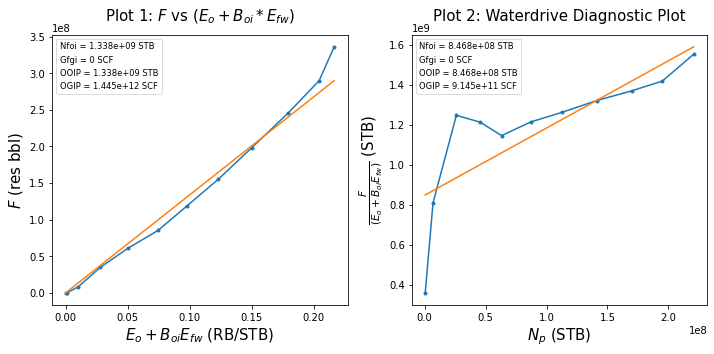

In [5]:


import warnings
warnings.filterwarnings("ignore")

temp = 195 # Initial reservoir temperature, F
swi = 0.2 # Initial water saturation
cw = 3E-6 # Water compressibility, sip
cf = 50E-6 # Formation compressibility, sip

# load production data of Valhall field
columns = ['date', 'z', 'p', 'Np', 'Rp', 'Wp', 'Wi', 'Bo', 'Rs']
df = pd.read_csv('valhall_proddata.csv', names=columns)

# convert date column to datetime format
df['date'] =  pd.to_datetime(df['date'], format='%d %B %Y')

# define input variables
t = df['date'].values
z = df['z'].values
p = df['p'].values
Np = df['Np'].values * 1E+6 # convert to STB
Rp = df['Rp'].values
Wp = df['Wp'].values
Wi = df['Wi'].values
Bo = df['Bo'].values
Rs = df['Rs'].values

# calculate Gp using Rp and Np
Gp = Rp * Np 

# no injection, define Gi as zeros
Gi = np.zeros(len(df))

# because non-volatile, add Rv data as zeros
Rv = np.zeros(len(df))
df['Rv'] = Rv

# calculate Bg from z-factor
Bg = gas_fvf(z, temp, p)
Bg = Bg * 0.18 # convert res ft3/scf to RB/scf
df['Bg'] = Bg

# initialize with reservoir type: oil
type = oil()

# calculate MBAL parameters
F, Bto, Btg, Efw, Eo, Eg = oil.calculate_params(type, p, Bo, Bg, Rv, Rs, Np, Gp, 
                                                Gi, cf, cw, swi)

# display material balance plots
oil.plot(type, 'undersaturated', F, Bto, Btg, Efw, Eo, Eg, Np, Bo, Rs, Rv)
     


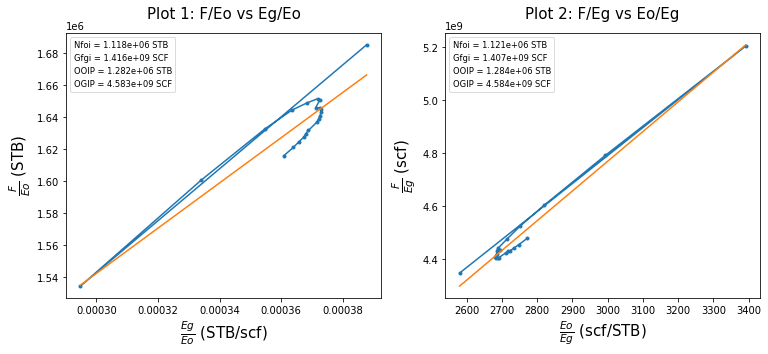

In [6]:
swi = 0 # Initial water saturation, not known
cw = 0 # Water compressibility, not known
cf = 0 # Formation compressibility, not known

# load production data of Prudhoe Bay
columns = ['p', 'Bo', 'Bg', 'Rs', 'Rv', 'Np', 'Gp']
df = pd.read_csv('Table 12.16 (edited).csv', names=columns)

# define input variables
p = df['p'].values
Bo = df['Bo'].values 
Bg = df['Bg'].values * (1 / 1E+3) # convert RB/MSCF to RB/SCF
Rs = df['Rs'].values
Rv = df['Rv'].values * (1 / 1E+6) # convert STB/MMSCF to STB/SCF
Np = df['Np'].values / 100
Gp = df['Gp'].values / 100

Gi = np.zeros(len(df)) # no gas injection

# initialize with reservoir type: oil
type = oil()

# calculate MBAL parameters
F, Bto, Btg, Efw, Eo, Eg = oil.calculate_params(type, p, Bo, Bg, Rv, Rs, Np, Gp, 
                                                Gi, cf, cw, swi)

# display material balance plots
oil.plot(type, 'saturated', F, Bto, Btg, Efw, Eo, Eg, Np, Bo, Rs, Rv, figsize=(16,5))